In [1]:
import sys
sys.path.append('../src')

In [2]:
from loading import *
from helpers import top_signals, sliding_window
from visualization import *
from matplotlib import pyplot as plt
%matplotlib inline

# Extract metrics for feature according to threshold value

In [3]:
data_path = "../data/"
patient_data = load_patient_seizures(data_path, 2,all_seizures=True, delta=1)

Seizure starts (s):  [[824604.12214844]
 [837451.78589844]]
Seizure ends (s):  [[824690.37769531]
 [837541.65542969]]
Duration (s):  [[86.25554687]
 [89.86953125]]
Sampled frequency (Hz):  512
Start/end [824604.12214844] [824690.37769531]
Start/end [837451.78589844] [837541.65542969]
EEG files:  [['../data/ID02/ID02_229h.mat', '../data/ID02/ID02_230h.mat', '../data/ID02/ID02_231h.mat'], ['../data/ID02/ID02_232h.mat', '../data/ID02/ID02_233h.mat', '../data/ID02/ID02_234h.mat']]
Hour of seizure:  [array([229, 230, 231]), array([232, 233, 234])]
Samples ranges:  [(104510, 148673), (1152914, 1198927)]


In [4]:
eegs = patient_data['eegs']
ranges = patient_data['ranges']
seizure_start_s = patient_data["infos"]["seizure_start"]
seizure_end_s = patient_data["infos"]["seizure_end"] 

In [5]:
max_power_eeg = top_signals(eegs, ranges, top=1, id_seizure = None)
print(max_power_eeg)

[48]


## Convert seizure sample ranges into sliding window ranges

In [6]:
def convert_sample_ranges_to_window_ranges(ranges, win_size, step_size,n):
    number_of_slices = (n-win_size)/step_size + 1
    window_ranges = []
    for (start_range, end_range) in ranges:
        start_window_range = int(start_range*(number_of_slices/n))
        end_window_range = int(end_range*(number_of_slices/n))
        window_ranges.append((start_window_range, end_window_range))
    return window_ranges

In [7]:
window_size = 128
step_size = 64

In [8]:
indexes = convert_sample_ranges_to_window_ranges(ranges,window_size,step_size,1843200)
print(indexes)

[(1632, 2322), (18013, 18732)]


# Computing signal energy with window

In [9]:
def calculate_energy(signal):
    return sum(pow(signal,2))

In [10]:
def calculate_feature(eegs, sensor, window_size, step_size, feature):
    """
    This function apply a specific feature to a signal using windows.
    
    Parameters
    ----------
    eegs : list
        A list containing a list of seizure data. 
        Each list of seizure data contains a list of array for one 
        or several hours of records for this seizure
    sensor : int
        ID of the sensors we want to process
    window_size: int
        Size of the window for the sliding window processing
    step_size: int
        Step size to move the window onto the signal
    feature: function
        Function computing the feature on a window of data

    Returns
    -------
    list
        Returns a list with the same hierarchy as input eegs list with
        the computed features of the signals.
    """

    energy_signals = []

    for seizure_eegs in eegs:
        seizure_energy_signals = []

        for eeg in seizure_eegs:
            signal = eeg[sensor]
            windows = sliding_window(signal, window_size, step_size)

            energy_signal = []
            for window in windows:
                energy_signal.append(feature(window))

            seizure_energy_signals.append(energy_signal)
        energy_signals.append(seizure_energy_signals)

    return energy_signals

In [11]:
energy_feature_signals = calculate_feature(eegs, max_power_eeg[0], window_size, step_size, calculate_energy)

28799
28799
28799
28799
28799
28799


## Plotting the obtained signals

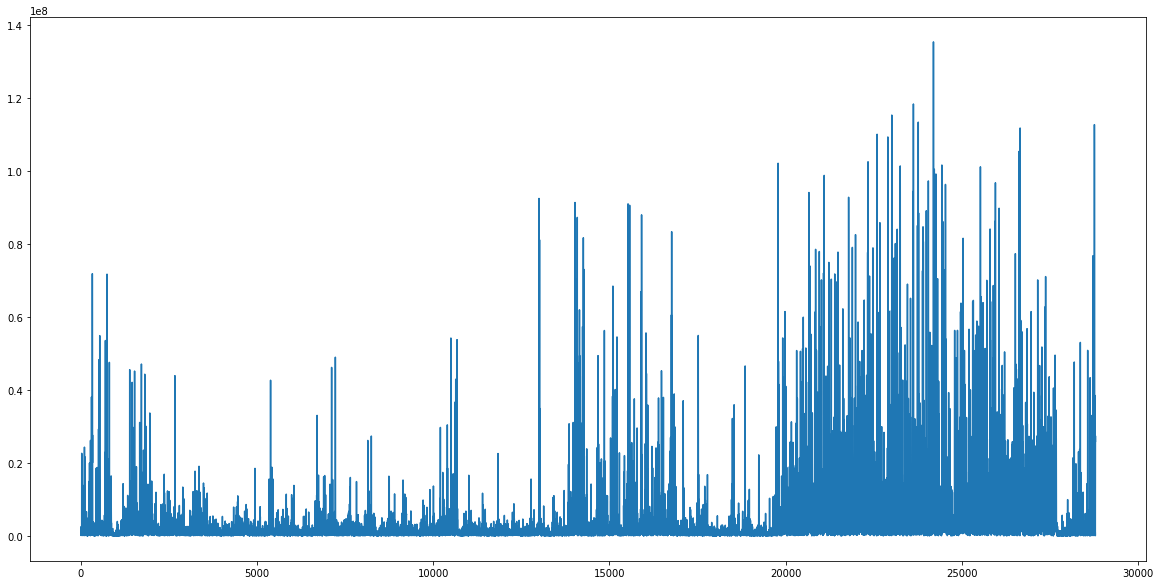

In [12]:
plt.figure(figsize=(20,10))
plt.plot(energy_feature_signals[0][0])

[]

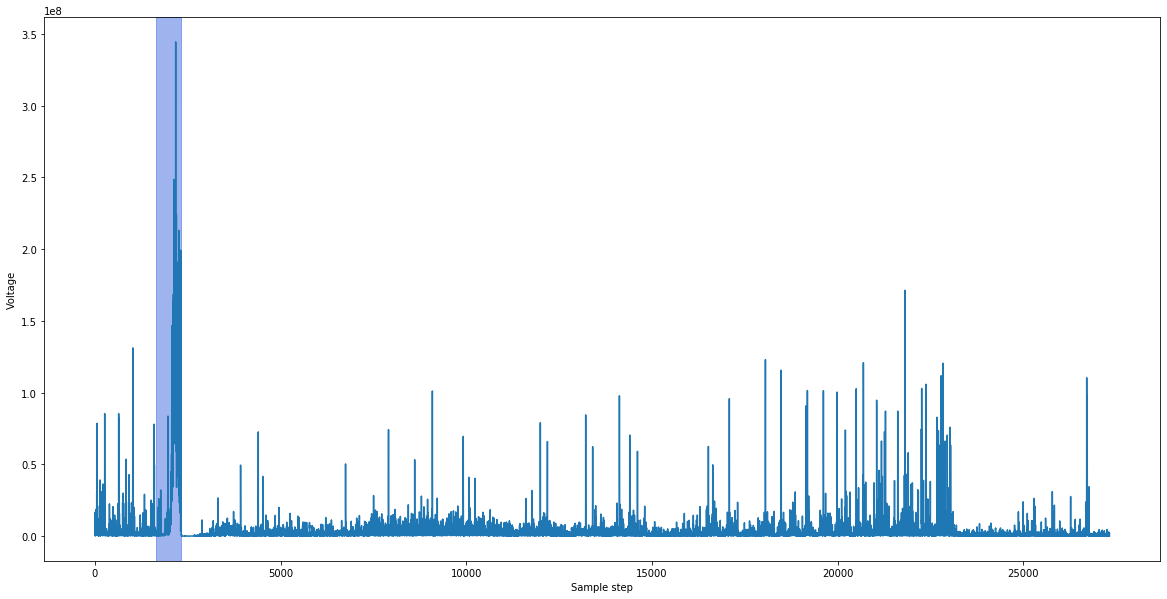

In [13]:
plot_one_signal(energy_feature_signals[0][1] , indexes, 50000, seizure_id=0)

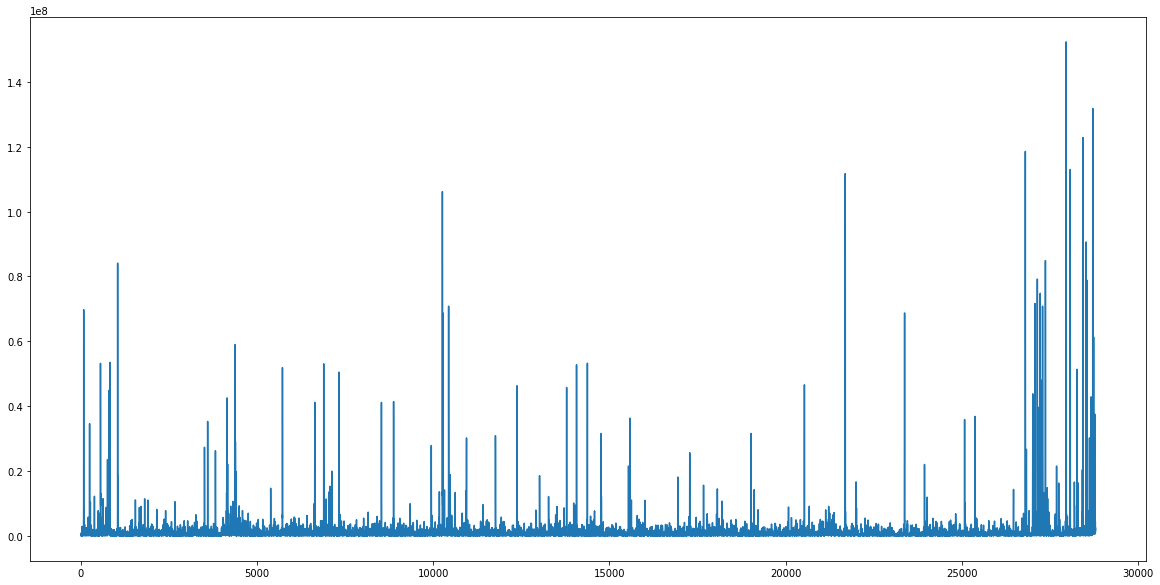

In [14]:
plt.figure(figsize=(20,10))
plt.plot(energy_feature_signals[0][2])

# Merging arrays of multiple files

In [15]:
def merge_seizures_data(data, window_ranges):
    """
    This function merge the different data obtain for each seizure together.
    
    Parameters
    ----------
    data : list
        A list containing a list of seizure data. 
        Each list of seizure data contains a list of array for one 
        or several hours of records for this seizure
    window_ranges : list
        list of tupples containing the ranges of seizures expressed in
        window indexes.

    Returns
    -------
    list, list
        Return:
            - A list containing the merged data for each seizure (one array of data per seizure)
            - A list of the updated window ranges for each seizure with an offset resulting from the merge
    
    """
    all_energy_signals = []
    new_indexes = []
    number_of_seizures = len(data)
    
    for i,seizure_signals in enumerate(data):
        merged_seizure_signals = []
        
        #Calculate index of seizure (always the middle table of data)
        index_seizure = len(seizure_signals)//2
        
        # Calculate the new index position after merge
        n = len(seizure_signals[0])
        offset = index_seizure * n
        new_indexes.append((indexes[i][0] + offset , indexes[i][1] + offset ))
        
        # Merge seizure signals
        for energy_signal in seizure_signals:
            merged_seizure_signals += energy_signal
        
        # Add merged seizure signals to output
        all_energy_signals.append(merged_seizure_signals)

    return new_indexes, all_energy_signals

In [16]:
def merge_all_data(data, window_ranges):
    """
    This function merge all seizure data together.
    
    Parameters
    ----------
    data : list
        A list containing a list of seizure data. 
        Each list of seizure data contains a list of array for one 
        or several hours of records for this seizure
    window_ranges : list
        list of tupples containing the ranges of seizures expressed in
        window indexes.

    Returns
    -------
    list, list
        Return:
            - A list containing the merged data.
            - A list of the updated window ranges for each seizure with an offset resulting from the merge.
    
    """
    all_energy_signals = []
    new_indexes = []
    number_of_seizures = len(data)
    
    for i,seizure_signals in enumerate(data):
        merged_seizure_signals = []
        
        #Calculate index of seizure (always the middle table of data)
        number_of_files = len(seizure_signals)
        index_seizure = number_of_files//2
        
        # Calculate the new index position ofter merge
        n = len(seizure_signals[0])
        offset = index_seizure * n + i * n * number_of_files
        new_indexes.append((indexes[i][0] + offset , indexes[i][1] + offset ))
        
        for energy_signal in seizure_signals:
            merged_seizure_signals += energy_signal

        all_energy_signals += merged_seizure_signals
    return new_indexes, all_energy_signals

## Checking the obtained result for merge_seizure_data

In [17]:
seizures_window_ranges, seizures_data = merge_seizures_data(energy_feature_signals, indexes)

In [18]:
print("Number of seizure",len(seizures_data))
print("Size of 1 seizure data",len(seizures_data[0]))
print("Past indices", indexes)
print("New indices (merge_on_seizure)", seizures_window_ranges)

Number of seizure 2
Size of 1 seizure data 86397
Past indices [(1632, 2322), (18013, 18732)]
New indices (merge_on_seizure) [(30431, 31121), (46812, 47531)]


In [19]:
print("Check size of 1 seizure data :", 28799*3)
print("Check first seizure offset", 28799+1632,28799+2322)
print("Check second seizure offset", 28799+18013, 28799+18732)

Check size of 1 seizure data : 86397
Check first seizure offset 30431 31121
Check second seizure offset 46812 47531


## Checking the obtained result for merge_all_data

In [20]:
all_data_window_ranges, all_data = merge_all_data(energy_feature_signals, indexes)

In [21]:
print("Size of data",len(all_data))
print("Past indices", indexes)
print("New indices (merge_on_seizure)", all_data_window_ranges)

Size of data 172794
Past indices [(1632, 2322), (18013, 18732)]
New indices (merge_on_seizure) [(30431, 31121), (133209, 133928)]


In [22]:
print("Check size of data :", 28799*3*2)
print("Check first seizure offset", 28799+1632,28799+2322)
print("Check second seizure offset", 28799*3+28799+18013, 28799*3+28799+18732)

Check size of data : 172794
Check first seizure offset 30431 31121
Check second seizure offset 133209 133928


## Plotting the results

### First seizure result

[]

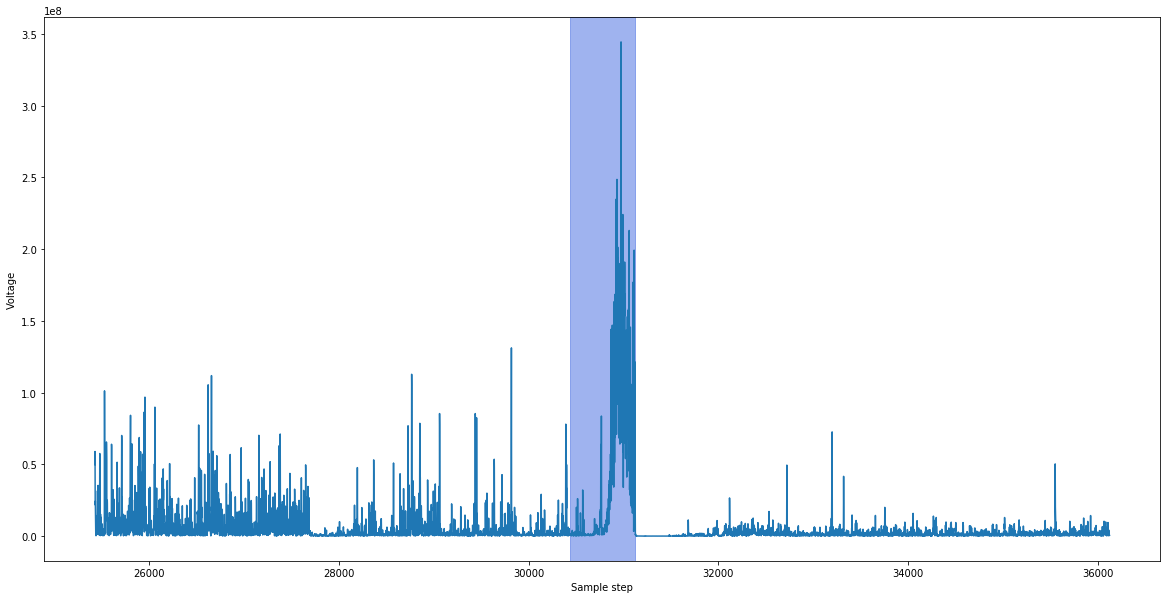

In [23]:
plot_one_signal(seizures_data[0] , seizures_window_ranges, 10000, seizure_id=0)

### Second seizure results

[]

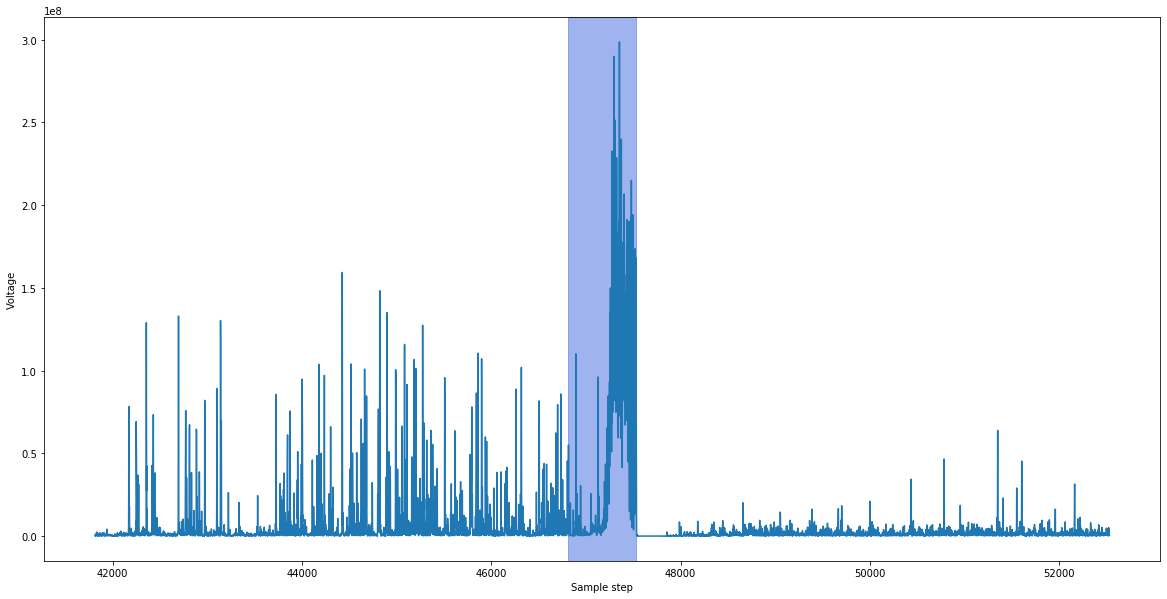

In [24]:
plot_one_signal(seizures_data[1] , seizures_window_ranges, 10000, seizure_id=1)

## All seizures result

[]

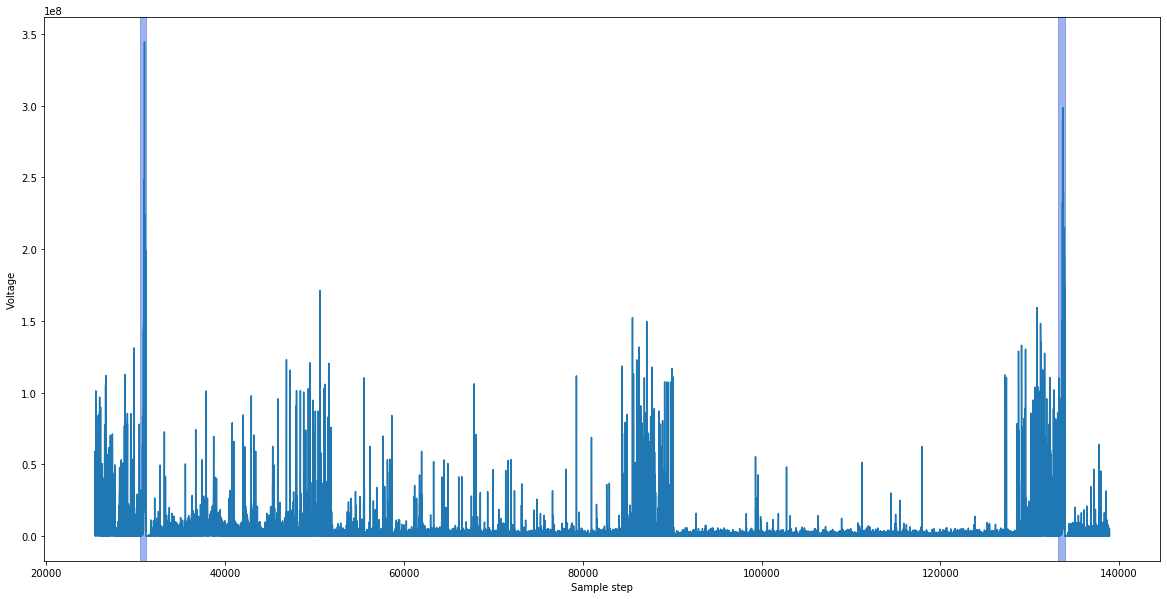

In [25]:
plot_one_signal(all_data , all_data_window_ranges, 10000)

# Plotting real signal and computed energy signal

In [26]:
def scale_signal(signal, win_size, step_size):
    """
    This function scales the processed data (using windows) 
    to fit the dimension of the input signal.
    """
    scaled_signal = [0]*step_size
    
    for point in signal:
        scaled_signal += [point]*step_size
    
    return scaled_signal

In [27]:
energy_seizure1_single = energy_feature_signals[0][1]
energy_seizure1_single_scaled = scale_signal(energy_seizure1_single, 128, 64)

In [28]:
seizure1_single = eegs[0][1][max_power_eeg].T

In [29]:
print("Feature signal before scaling", len(energy_seizure1_single))
print("Feature signal after scaling", len(energy_seizure1_single_scaled))
print("Original signal", len(seizure1_single))

Feature signal before scaling 28799
Feature signal after scaling 1843200
Original signal 1843200


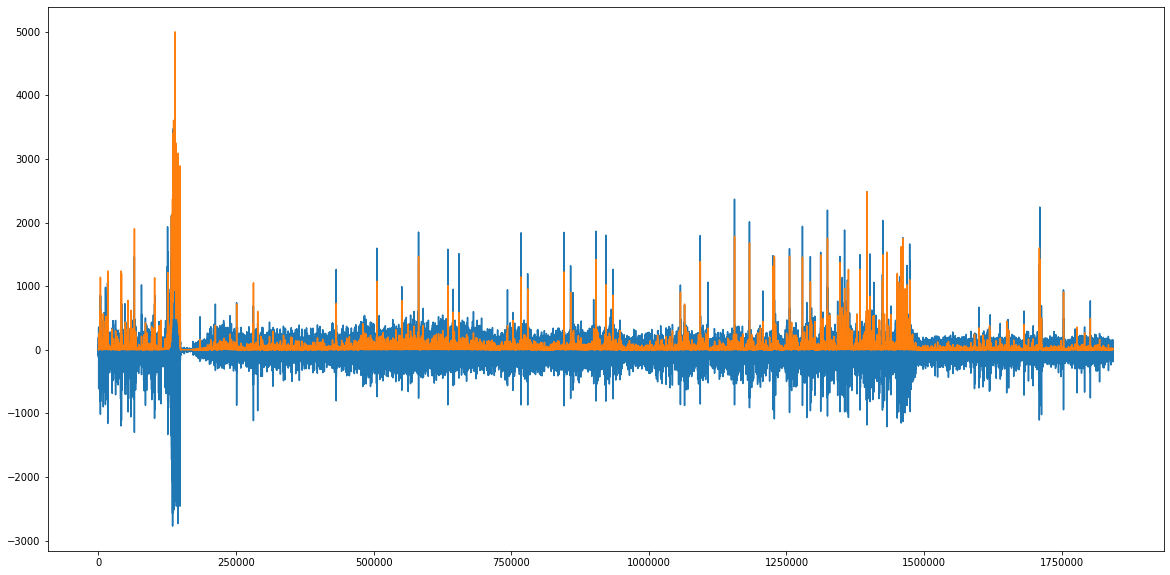

In [30]:
plt.figure(figsize=(20,10))
plt.plot(seizure1_single)
plt.plot(energy_seizure1_single_scaled/np.max(energy_seizure1_single_scaled)*5000)

# Calculate metrics according to the threshold value

## Calculate False Alarm

False alarms are calculated by:
* removing the part of the signal where the seizure occurs (we won't find false alarm here)
* Rescaling the signal values between 0 and 1
* Counting the number of elements (1) in the list generated by np.where (a value of this list is equal to one if the corresponding signal value is superior or equal to the threshold

In [31]:
def false_alarm(signal, indexes, threshold):

    # Delete values inside seizure
    signal_without_seizure = np.delete(signal, np.arange(indexes[0][0], indexes[0][1], 1))
    # Rescale values
    signal_without_seizure = signal_without_seizure / np.max(signal_without_seizure)
    #Count the number of false alarm according to the threshold
    false_alarm = np.sum(np.where(signal_without_seizure >= threshold, 1, 0))

    return false_alarm

### Check the result of false alarm

We expect to have the number of false alarms equal to the number of non seizure samples in the case of a null threeshold. And we expect to have a false alarm of 0 with a threshold superior to 1 (we don't detect any event in the signal).

In [32]:
print(false_alarm(all_data, all_data_window_ranges, 0))
print(len(all_data) - (all_data_window_ranges[0][1]- all_data_window_ranges[0][0]))

172104
172104


In [33]:
print(false_alarm(all_data, all_data_window_ranges, 1.01))

0


## Calculate Delay

In [34]:
def delay(signal, indexes, threshold):
    delays = []
    for seizure_start, seizure_end in indexes:
        seizure_signal = signal[seizure_start:seizure_end+1]
        delay_count = 0

        # Normalize values
        seizure_signal = seizure_signal/ np.max(seizure_signal)

        for e in seizure_signal:
            if e < threshold:
                delay_count +=1
            else:
                break
        delays.append(delay_count)
    return delays

### Check the result of delay

In [35]:
print(delay(all_data, all_data_window_ranges, 0))

[0, 0]


In [36]:
print(delay(all_data, all_data_window_ranges, 1))
print(np.argmax(all_data[all_data_window_ranges[0][0]:all_data_window_ranges[0][1]+1]))
print(np.argmax(all_data[all_data_window_ranges[1][0]:all_data_window_ranges[1][1]+1]))

[543, 541]
543
541


## Calculate precision

In [37]:
def precision(signal, indexes, threshold):
    max_energy = np.max(signal[indexes[0][0]:indexes[0][1]]+signal[indexes[1][0]:indexes[1][1]])
    detection = 0
    for start, end in indexes:
            seizure_signal = signal[start:end+1]
            # Normalize values
            seizure_signal = seizure_signal/max_energy
            
            if np.max(seizure_signal) >= threshold:
                detection += 1
            
    return detection/len(indexes)

In [38]:
print(precision(all_data, all_data_window_ranges, 0))

1.0


In [39]:
print(precision(all_data, all_data_window_ranges, 1))

0.5


In [40]:
print(precision(all_data, all_data_window_ranges, 0.9))

0.5


# Plotting the functions

In [41]:
def compute_metrics(data, ranges):
    thresholds = np.arange(0,1,0.0001)
    false_alarms = []
    delays = []
    precisions = []

    for t in list(thresholds):
        false_alarms.append(false_alarm(data, ranges, t))
        delays.append(delay(data, ranges, t))
        precisions.append(precision(data, ranges, t))
        
    return thresholds, false_alarms, delays, precisions
    

In [42]:
def plot_metrics(thresholds, false_alarms, delays, precision):
    fig, axs =  plt.subplots(2, 2,figsize=(20, 10))
    
    axs[0,0].plot(false_alarms, thresholds)
    axs[0,0].set_ylabel('Threshold')
    axs[0,0].set_xlabel('False Alarm')
    
    for i in range(len(delays[0])):
        axs[0,1].plot([pt[i] for pt in delays], thresholds, label = 'seizure %s'%i)
    axs[0,1].set_ylabel('Threhold')
    axs[0,1].set_xlabel('Delays')
    
    axs[1,0].plot(precision, thresholds)
    axs[1,0].set_ylabel('Threshold')
    axs[1,0].set_xlabel('Precision')
    
    for i in range(len(delays[0])):
        axs[1,1].plot([pt[i] for pt in delays], false_alarms, label = 'seizure %s'%i)
    axs[1,1].set_ylabel('Delays')
    axs[1,1].set_xlabel('False Alarm')
    

In [43]:
thresholds, false_alarms, delays, precisions = compute_metrics(all_data, all_data_window_ranges)

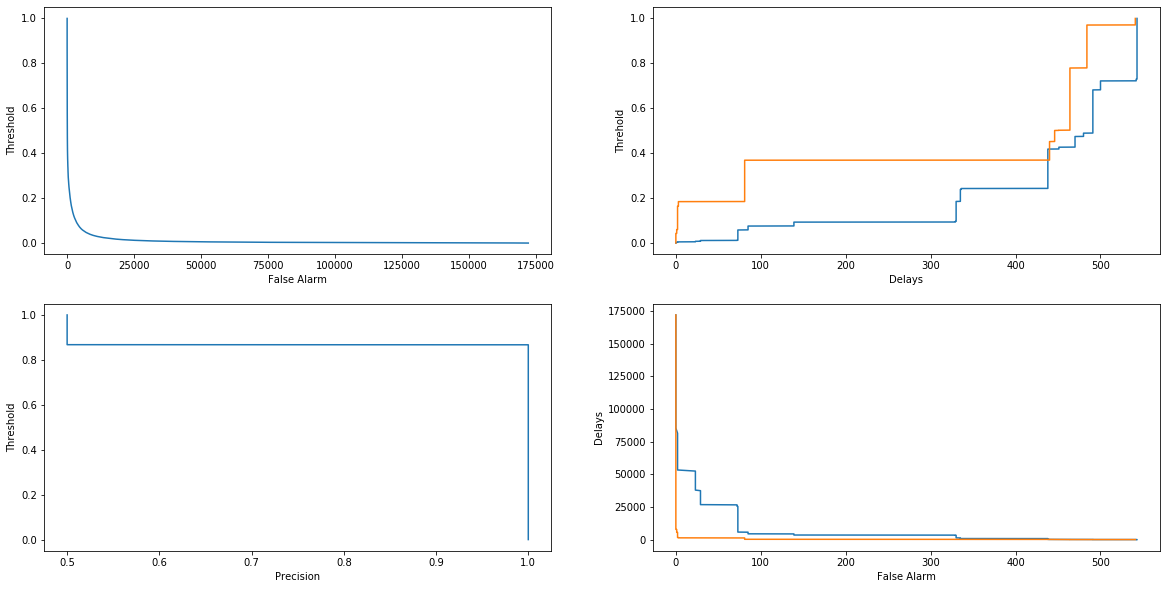

In [44]:
plt_all_metrics = plot_metrics(thresholds, false_alarms, delays, precisions)

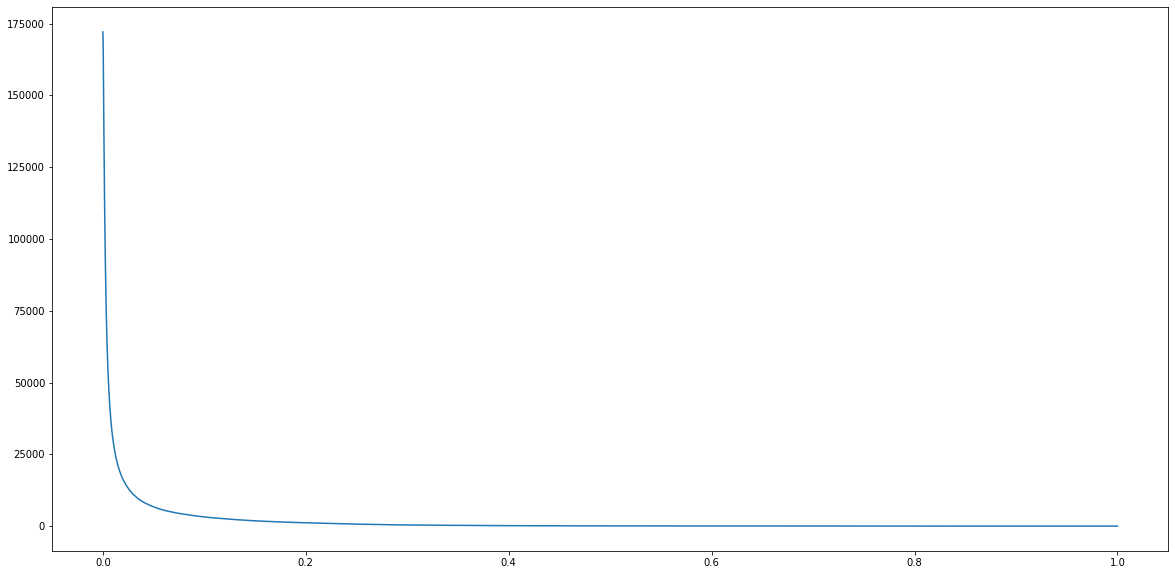

In [45]:
plt.figure(figsize=(20,10))
plt.plot(thresholds, false_alarms)

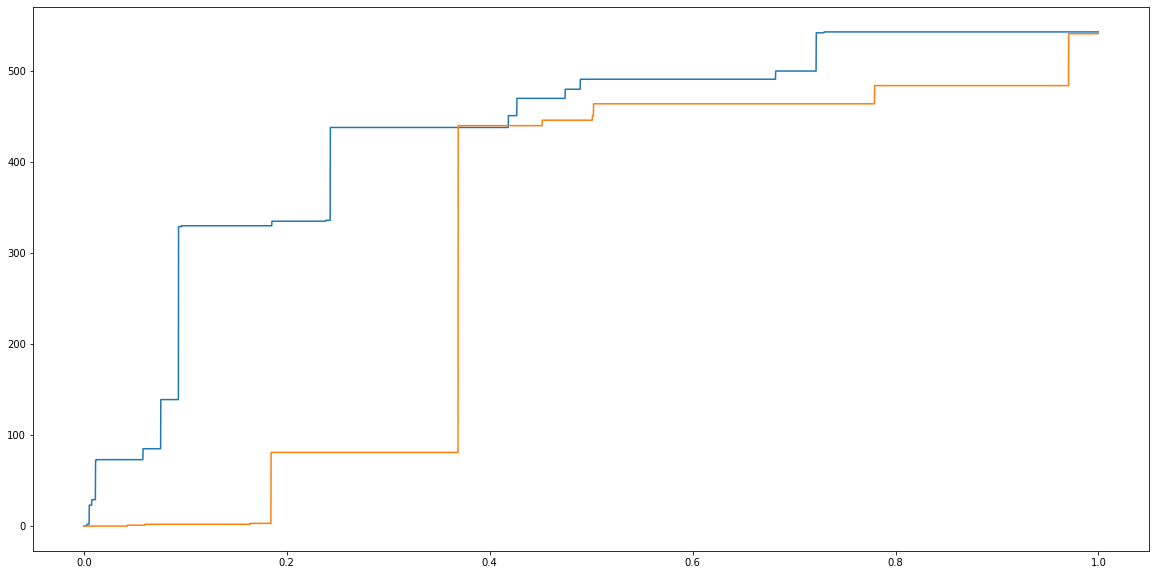

In [46]:
plt.figure(figsize=(20,10))
for i in range(len(delays[0])):
    plt.plot(thresholds, [pt[i] for pt in delays],label = 'seizure %s'%i)
plt.show()

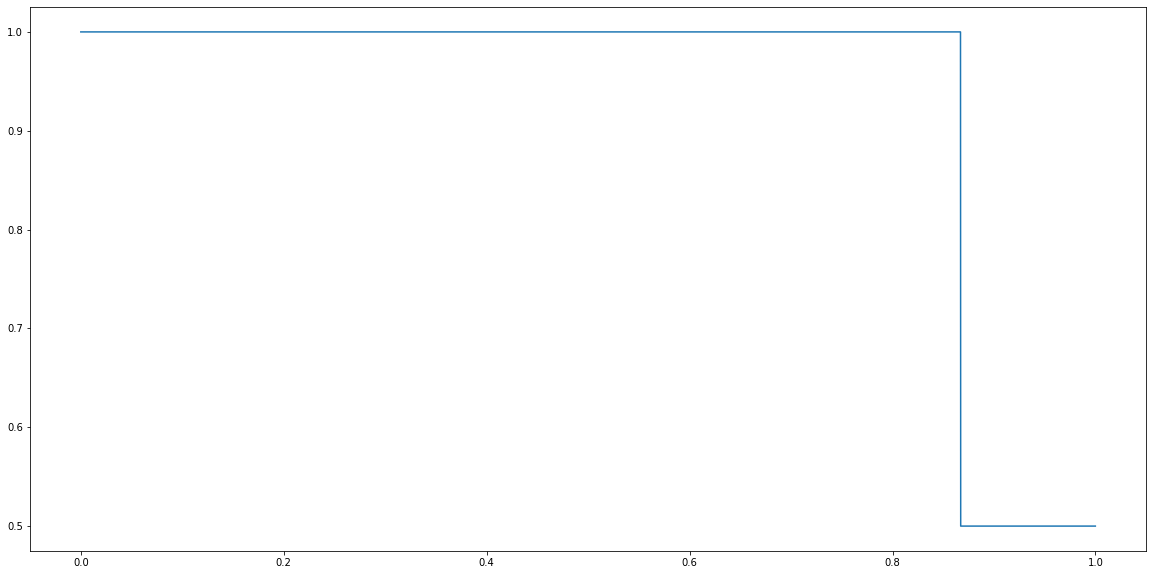

In [47]:
plt.figure(figsize=(20,10))
plt.plot(thresholds, precisions)
plt.show()

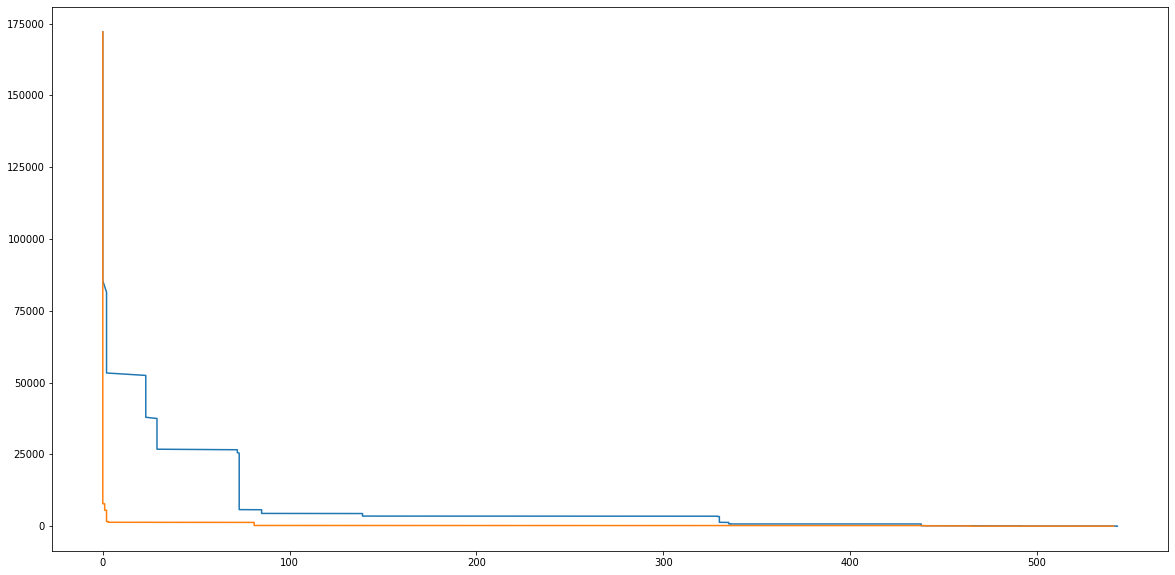

In [48]:
plt.figure(figsize=(20,10))
for i in range(len(delays[0])):
    plt.plot([pt[i] for pt in delays], false_alarms, label = 'seizure %s'%i)
plt.show()

In [49]:
w1, w2, w3 = (1/25000,1/500,1)
final_cost_function = []
for i in range(len(delays[1])):
    final_cost_function.append(w1*np.array(false_alarms) - w2*np.array([pt[i] for pt in delays]) + w3*np.array(precisions))

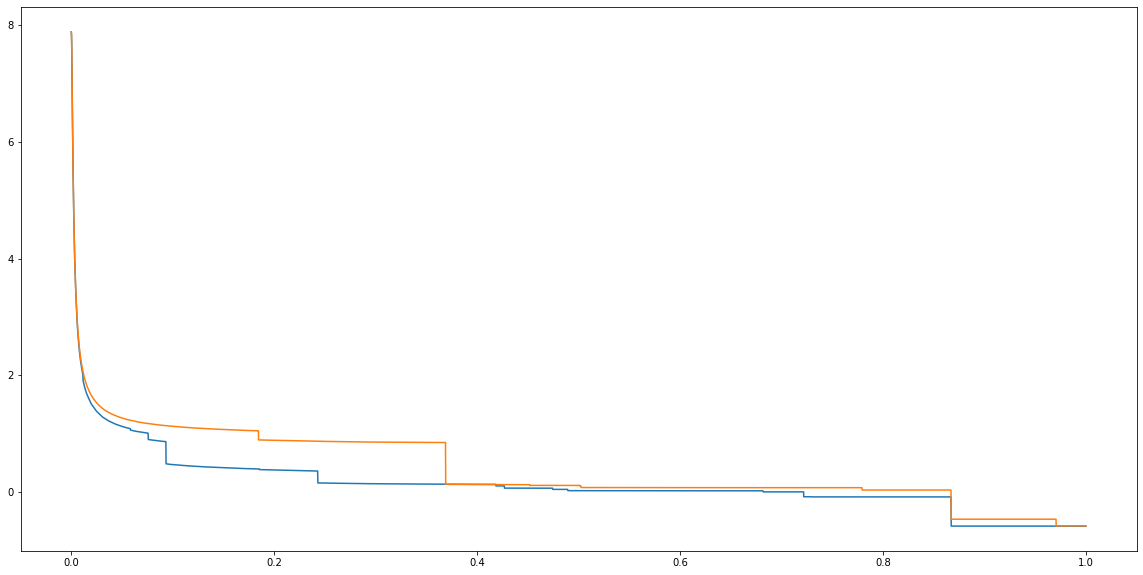

In [50]:
plt.figure(figsize=(20,10))
for final_cost in final_cost_function:
    plt.plot(thresholds, final_cost)